Reading CSV files of Toronto station data, Toronto bike trip data, Toronto traffic data, and Toronto weather data into separate dataframes. Also merging the 2010s and 2020s traffic data into a single dataframe called raw_traffic.

In [9]:
# Reading all of the csv files that I need: station data, bike trips data, traffic data, and weather data
import pandas as pd
stations = pd.read_csv('/Users/fabjoseph/Desktop/CSE_Project/data/raw/stations_latlong.csv')
trips = pd.read_csv('/Users/fabjoseph/Desktop/CSE_Project/data/raw/trips.csv')
weather = pd.read_csv('/Users/fabjoseph/Desktop/CSE_Project/data/raw/weather.csv')
raw_traffic_2010s= pd.read_csv('/Users/fabjoseph/Desktop/CSE_Project/data/raw/raw-data-2010-2019.csv')
raw_traffic_2020s= pd.read_csv('/Users/fabjoseph/Desktop/CSE_Project/data/raw/raw-data-2020-2029.csv')
raw_traffic = pd.concat([raw_traffic_2010s, raw_traffic_2020s], ignore_index=True) #Merging traffic data so its all in one

Filtering all of the datasets from the years 2016 to 2020, which is the time range of the station dataset. Beofre filtering need to convert date columns in the trips, weather, and raw traffic dataframe to datetime format.

In [10]:
# The station dataset goes from 2016 to 2020 so lets filter all of my datasets to this time range
# Convert columns to datetime so they can be filtered by year
trips['start_date'] = pd.to_datetime(trips['start_date'])
weather['date'] = pd.to_datetime(weather['date'])
raw_traffic['count_date'] = pd.to_datetime(raw_traffic['count_date'])
# Now filter the datasets for the years 2016 to 2020
stations = stations[(stations['yearid'] >= 2016) & (stations['yearid'] <= 2020)]
trips = trips[(trips['start_date'].dt.year >= 2016) & (trips['start_date'].dt.year <= 2020)]
weather = weather[(weather['date'].dt.year >= 2016) & (weather['date'].dt.year <= 2020)]
raw_traffic = raw_traffic[(raw_traffic['count_date'].dt.year >= 2016) & (raw_traffic['count_date'].dt.year <= 2020)]

Finding the nearest traffic location to each bike station using the Haversine distance because it is computationally efficient for calculating distances between coordinates. This information is being merged into a single dataframe called merged_data.

In [11]:
#!pip install scikit-learn
#trying to find nearest traffic locations to our stations dataset. This runs quicker if we use haversine distance
import numpy as np
from tqdm import tqdm
# Function to calculate the haversine distance between two sets of coordinates. This is computationally faster!
def haversine_vectorized(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, [lat1, lng1, lat2, lng2])  #Convert latitude and longitude from degrees to radians 
    dlat = lat2 - lat1[:, np.newaxis] #difference in latitude
    dlng = lng2 - lng1[:, np.newaxis] #difference in longitdue
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1)[:, np.newaxis] * np.cos(lat2) * np.sin(dlng / 2) ** 2 #calculate a
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)) #Calculate 'c'
    return 6371000 * c     # Return distance
station_coords = stations[['latitude', 'longitude']].values # Place station and traffic coordinates as NumPy arrays 
traffic_coords = raw_traffic[['lat', 'lng']].values # Place station and traffic coordinates as NumPy arrays 
chunk_size = 100 # Setting chunk size to process a manageable number of stations
num_chunks = int(np.ceil(station_coords.shape[0] / chunk_size)) # Setting chunk size to process a manageable number of stations
nearest_traffic_location = [] # Create lists to traffic location
nearest_traffic_id = [] # Create lists to store traffic id
# Run formula in chunks
for i in tqdm(range(num_chunks), desc="Finding nearest traffic stations"):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, station_coords.shape[0])
    # Calculate distancess for the current chunk using haversine 
    distances_chunk = haversine_vectorized(
        station_coords[start_idx:end_idx, 0],
        station_coords[start_idx:end_idx, 1],
        traffic_coords[:, 0],
        traffic_coords[:, 1]
    )
    nearest_indices = np.argmin(distances_chunk, axis=1) #nearest indice
    nearest_traffic_location.extend(raw_traffic.iloc[nearest_indices]['location'].values)#Append results 
    nearest_traffic_id.extend(raw_traffic.iloc[nearest_indices]['location_id'].astype(str).values) #Append results 
stations['nearest_traffic_location'] = nearest_traffic_location # Add the nearest location to stations DataFrame
stations['nearest_traffic_id'] = nearest_traffic_id # Add the nearest ID to the stations DataFrame
raw_traffic['location_id'] = raw_traffic['location_id'].astype(str).str.strip().str.lower() #Make sure location_id is the same
stations['nearest_traffic_id'] = stations['nearest_traffic_id'].str.strip().str.lower() #Make sure location_id is the same
merged_data = stations.merge(raw_traffic, left_on='nearest_traffic_id', right_on='location_id', suffixes=('_station', '_traffic')) # Merge stations with raw_traffic with nearest traffic IDs
print("Done, first five rows:")
merged_data.head()

Finding nearest traffic stations: 100%|█████████| 20/20 [00:08<00:00,  2.49it/s]


Done, first five rows:


,code,name,latitude,longitude,yearid,nearest_traffic_location,nearest_traffic_id,_id,count_id,count_date,...,ex_peds,wx_peds,nx_bike,sx_bike,ex_bike,wx_bike,nx_other,sx_other,ex_other,wx_other
0,0,Dundas St E / Regent Park Blvd,43.660546,-79.395757,2016,RUSSELL ST AT ST GEORGE ST,4995,10052,40283,2020-02-11,...,0.0,0.0,16.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0
1,0,Dundas St E / Regent Park Blvd,43.660546,-79.395757,2016,RUSSELL ST AT ST GEORGE ST,4995,10053,40283,2020-02-11,...,0.0,0.0,25.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0
2,0,Dundas St E / Regent Park Blvd,43.660546,-79.395757,2016,RUSSELL ST AT ST GEORGE ST,4995,10054,40283,2020-02-11,...,0.0,0.0,31.0,6.0,0.0,5.0,0.0,0.0,0.0,0.0
3,0,Dundas St E / Regent Park Blvd,43.660546,-79.395757,2016,RUSSELL ST AT ST GEORGE ST,4995,10055,40283,2020-02-11,...,0.0,0.0,30.0,11.0,0.0,11.0,0.0,0.0,0.0,0.0
4,0,Dundas St E / Regent Park Blvd,43.660546,-79.395757,2016,RUSSELL ST AT ST GEORGE ST,4995,10056,40283,2020-02-11,...,0.0,0.0,24.0,15.0,0.0,3.0,0.0,0.0,0.0,0.0


Showing the first five rows of the merged station and traffic data

Aggregating traffic data to create a dataset where each row is a differnet station with its summed up traffic metrics. Be wary of multiple rows repsrening same staiton because station dataset has different codes associated with it probably because station may have changed or something. Simply remove duplicates

In [12]:
# Aggregate traffic data so each row corresponds to a different station with aggregated traffic metrics
# List of traffic columns to sum (only the numeric traffic columns make sense to sum)
columns_to_sum = [
    'sb_cars_r', 'sb_cars_t', 'sb_cars_l', 'nb_cars_r', 'nb_cars_t', 'nb_cars_l', 'wb_cars_r', 'wb_cars_t', 'wb_cars_l',
    'eb_cars_r', 'eb_cars_t', 'eb_cars_l', 'sb_truck_r', 'sb_truck_t', 'sb_truck_l', 'nb_truck_r', 'nb_truck_t', 'nb_truck_l',
    'wb_truck_r', 'wb_truck_t', 'wb_truck_l', 'eb_truck_r', 'eb_truck_t', 'eb_truck_l', 'sb_bus_r', 'sb_bus_t', 'sb_bus_l',
    'nb_bus_r', 'nb_bus_t', 'nb_bus_l', 'wb_bus_r', 'wb_bus_t', 'wb_bus_l', 'eb_bus_r', 'eb_bus_t', 'eb_bus_l',
    'nx_peds', 'sx_peds', 'ex_peds', 'wx_peds', 'nx_bike', 'sx_bike', 'ex_bike', 'wx_bike', 'nx_other', 'sx_other',
    'ex_other', 'wx_other'
]
# Group by station code and station name, summing the numeric columns
aggregated_data = merged_data.groupby(['code', 'name']).agg({
    **{col: 'sum' for col in columns_to_sum},  # Sum traffic counts
    '_id': 'first',  # Keep the first value of _id
    'count_id': 'first',  # Keep the first value of count_id
    'nearest_traffic_location': 'first',  # Keep the nearest traffic location
    'nearest_traffic_id': 'first',  # Keep the nearest traffic ID
}).reset_index()
# Rename the 'name' column to 'station_name'
aggregated_data = aggregated_data.rename(columns={'name': 'station_name'})
# Reorder columns so it's clear
columns = ['station_name', 'nearest_traffic_location'] + [
    col for col in aggregated_data.columns if col not in ['station_name', 'latitude', 'longitude', 'nearest_traffic_location']
]
# Save to new DataFrame with the updated column order
aggregated_data = aggregated_data[columns]
#remove duplicates
aggregated_data= aggregated_data.drop_duplicates(subset=['station_name', 'nearest_traffic_location'])

# Show preview of data
aggregated_data.head()

,station_name,nearest_traffic_location,code,sb_cars_r,sb_cars_t,sb_cars_l,nb_cars_r,nb_cars_t,nb_cars_l,wb_cars_r,...,sx_bike,ex_bike,wx_bike,nx_other,sx_other,ex_other,wx_other,_id,count_id,nearest_traffic_id
0,Bay St / Albert St,ALBERT ST AT BAY ST (PX 65),0,0.0,7078.0,0.0,2.0,7399.0,0.0,1420.0,...,358.0,88.0,4.0,0.0,0.0,0.0,0.0,148529,34757,5421
1,Bond St / Queen St E,CHURCH ST AT QUEEN ST (PX 19),0,842.0,3888.0,471.0,676.0,4271.0,926.0,457.0,...,304.0,312.0,233.0,0.0,0.0,0.0,0.0,148401,34749,6091
2,Bremner Blvd / Rees St,LAKE SHORE BLVD AT REES ST (PX 1408),0,278.0,427.0,1974.0,568.0,436.0,211.0,599.0,...,9.0,2.0,2.0,0.0,0.0,0.0,0.0,185270,37143,3933
3,Bremner Blvd / Spadina Ave,BREMNER BLVD AT SPADINA AVE AND FORT YORK BLVD...,0,469.0,7039.0,453.0,1544.0,6103.0,319.0,286.0,...,36.0,40.0,63.0,0.0,0.0,0.0,0.0,208284,38597,5697
4,Dundas St E / Regent Park Blvd,RUSSELL ST AT ST GEORGE ST,0,213.0,1775.0,0.0,0.0,2738.0,572.0,0.0,...,409.0,0.0,100.0,0.0,0.0,0.0,0.0,10052,40283,4995


Merging weather data with bike trip counts to find relationships. I make a series of visuals

/var/folders/xp/l594z5310z5d1ygg9jm87glw0000gn/T/ipykernel_46022/3955213970.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  station_trip_weather_traffic['trip_count'].fillna(0, inplace=True)


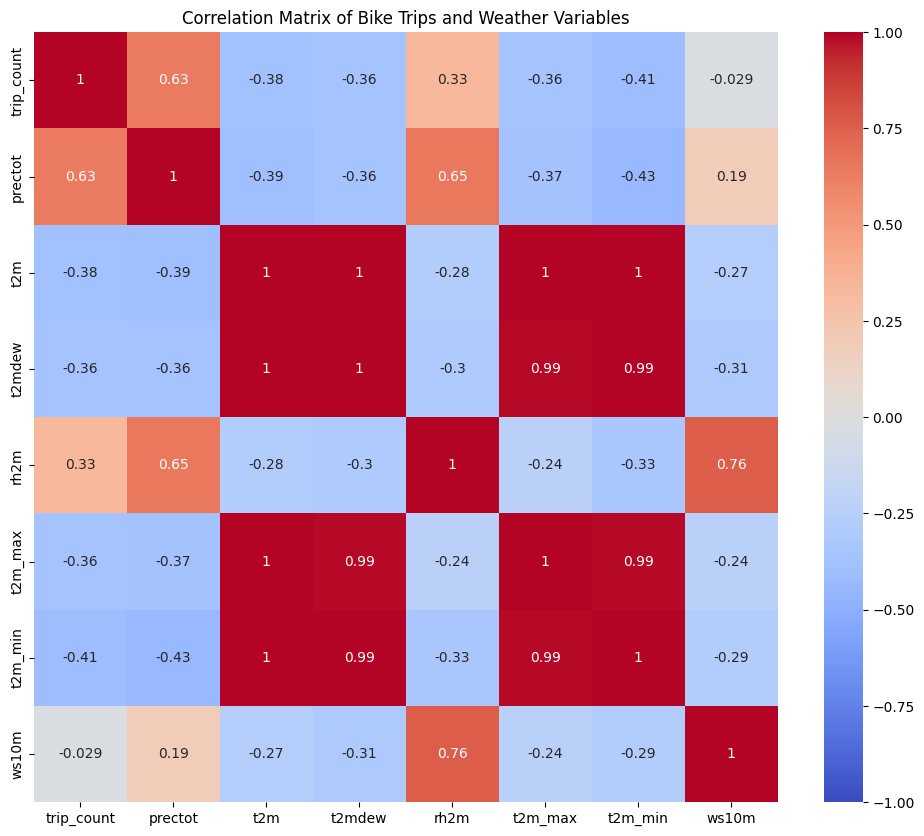

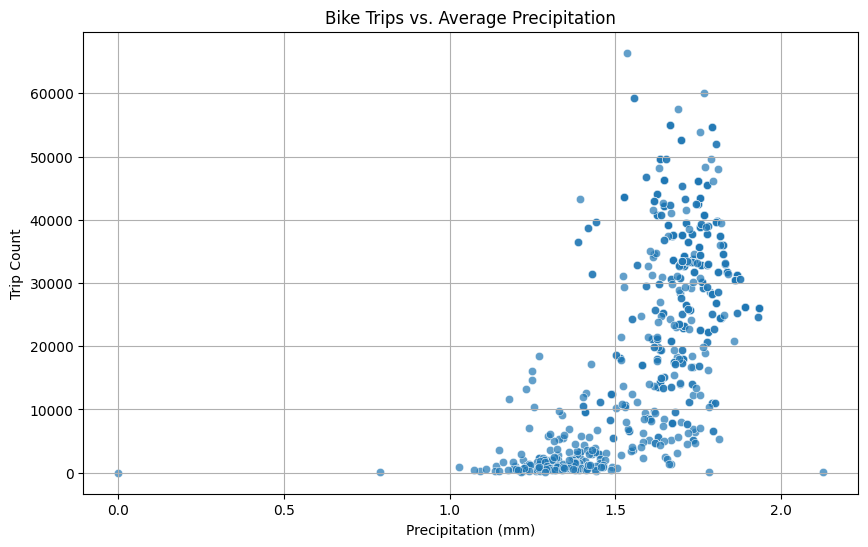

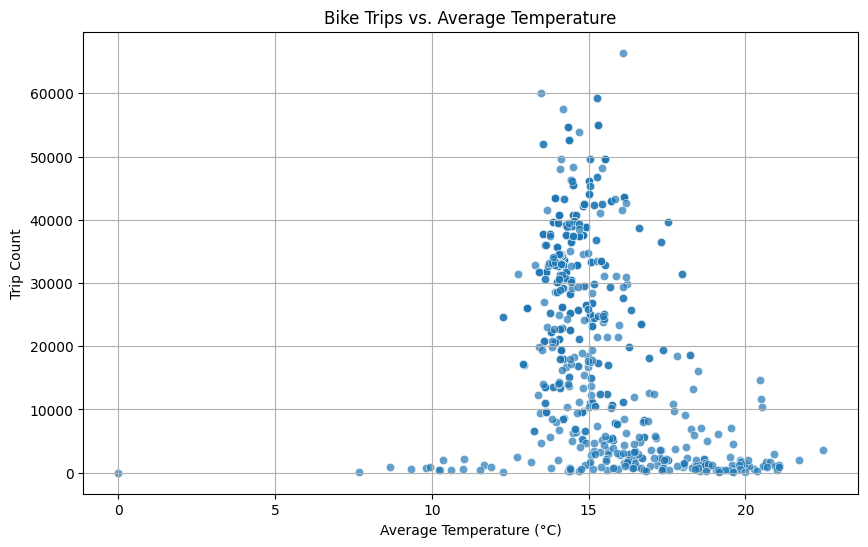

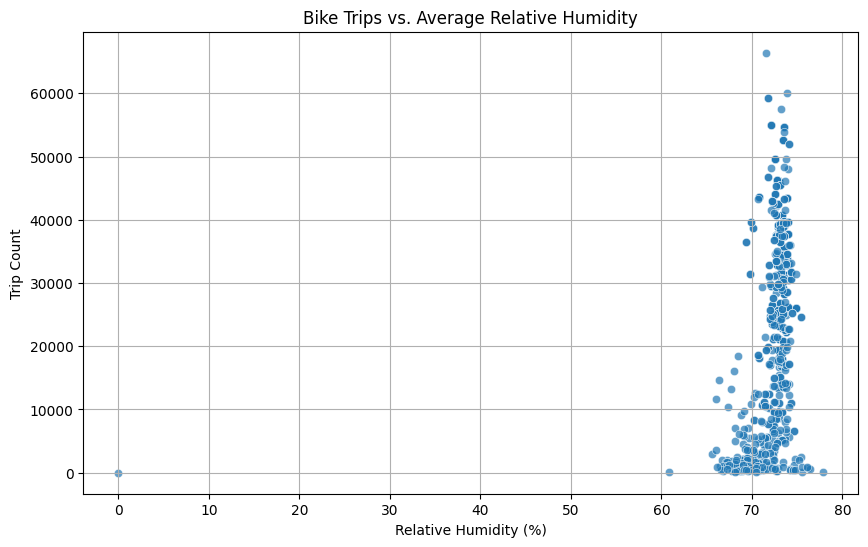

In [13]:
#merging weather data with station-traffic data and creating visuals to see relationship
#landing at average weather conditions for each station and associated trip counts
import matplotlib.pyplot as plt
import seaborn as sns
# Convert dates to datetime objects and extract date part
trips['trip_date'] = pd.to_datetime(trips['start_date']).dt.date
weather['date'] = pd.to_datetime(weather['date']).dt.date
trips_weather = trips.merge(weather, left_on='trip_date', right_on='date', how='left')# Merge trips with weather data on the date
trip_counts = trips_weather.groupby('start_station_code').size().reset_index(name='trip_count') #Calculate trip counts per station

# Merge trip counts with the aggregated station-traffic data
station_trip_weather_traffic = aggregated_data.merge(trip_counts, left_on='code', right_on='start_station_code', how='left')

# Add weather variables to the merged DataFrame
weather_agg = trips_weather.groupby('start_station_code')[['prectot', 't2m', 't2mdew', 'rh2m', 't2m_max', 't2m_min', 'ws10m'
]].mean().reset_index()
station_trip_weather_traffic = station_trip_weather_traffic.merge(
    weather_agg, left_on='code', right_on='start_station_code', how='left'
)
# Fill NaN values with 0
station_trip_weather_traffic['trip_count'].fillna(0, inplace=True)
station_trip_weather_traffic.fillna(0, inplace=True)
duplicates = station_trip_weather_traffic[station_trip_weather_traffic.duplicated(subset='station_name', keep=False)]
station_trip_weather_traffic = station_trip_weather_traffic.drop_duplicates(subset='station_name') # Drop duplicates 
# Creating Correlation Matrix with Weather Variables
weather_corr = station_trip_weather_traffic[['trip_count', 'prectot', 't2m', 't2mdew', 'rh2m', 't2m_max', 't2m_min', 'ws10m']].corr()
# Creating Heatmap of Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(weather_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Bike Trips and Weather Variables')
plt.show()
# Scatter Plot: Bike Trips vs. Precipitation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=station_trip_weather_traffic, x='prectot', y='trip_count', alpha=0.7)
plt.title('Bike Trips vs. Average Precipitation')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Trip Count')
plt.grid(True)
plt.show()
# Scatter Plot:  Bike Trips vs. Average Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(data=station_trip_weather_traffic, x='t2m', y='trip_count', alpha=0.7)
plt.title('Bike Trips vs. Average Temperature')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Trip Count')
plt.grid(True)
plt.show()
# Scatter Plot: Bike Trips vs. Relative Humidity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=station_trip_weather_traffic, x='rh2m', y='trip_count', alpha=0.7)
plt.title('Bike Trips vs. Average Relative Humidity')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Trip Count')
plt.grid(True)
plt.show()

Merging traffic data with bike trip counts to find relationships. I make a series of visuals

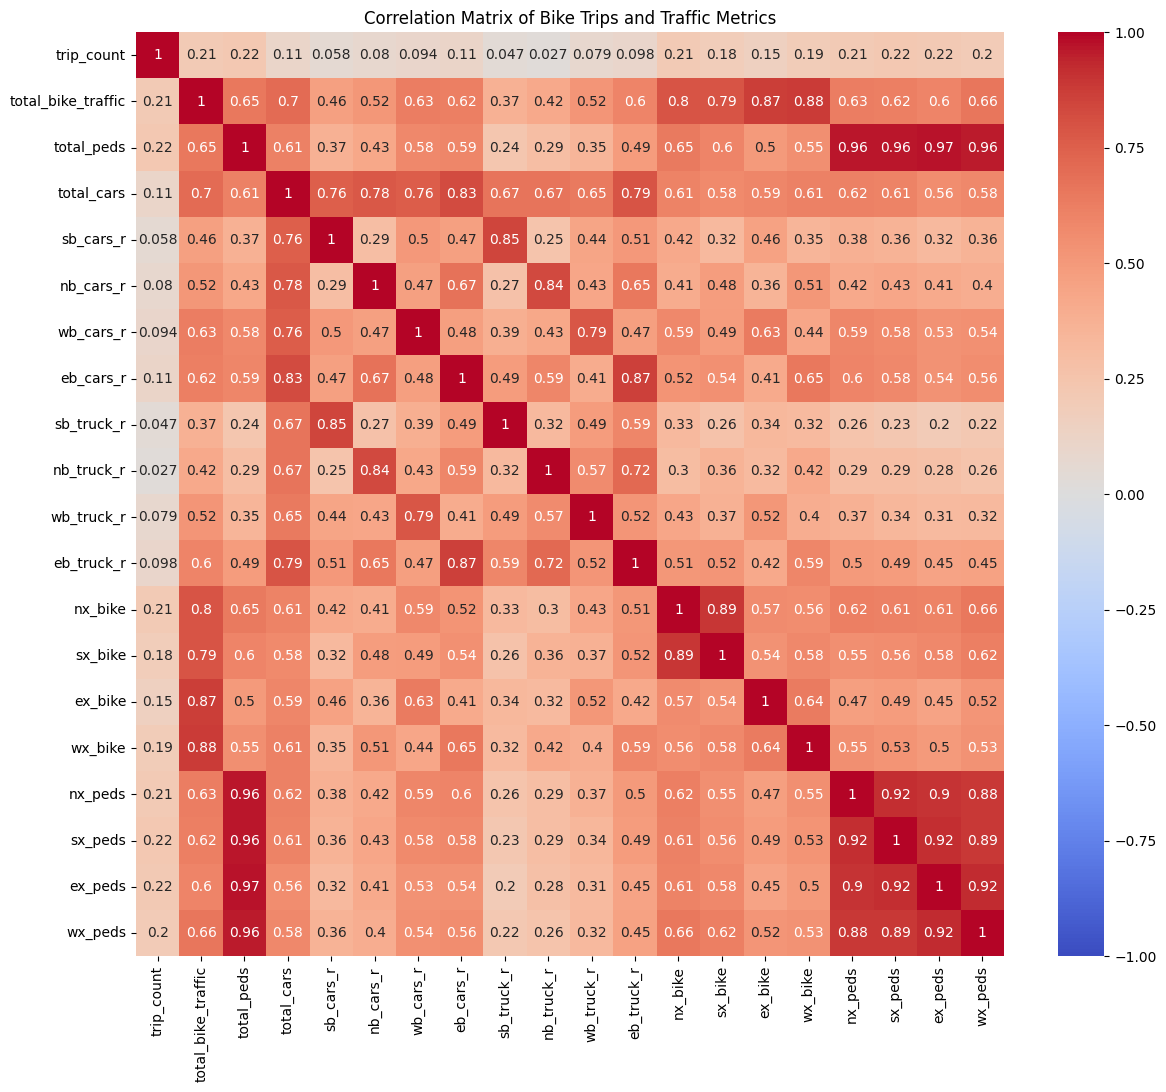

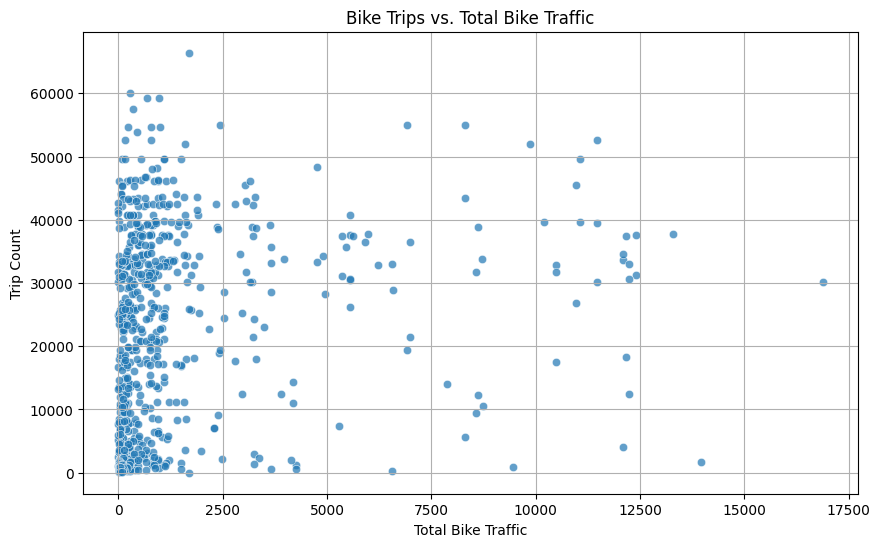

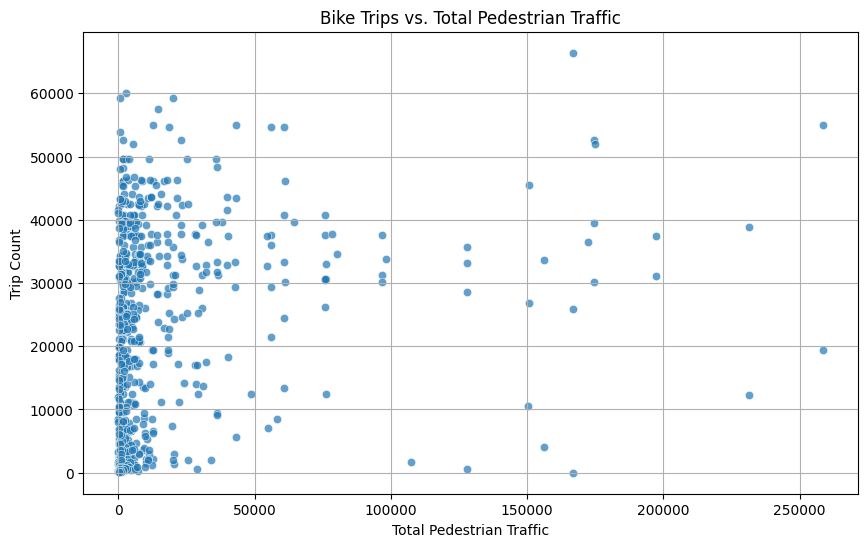

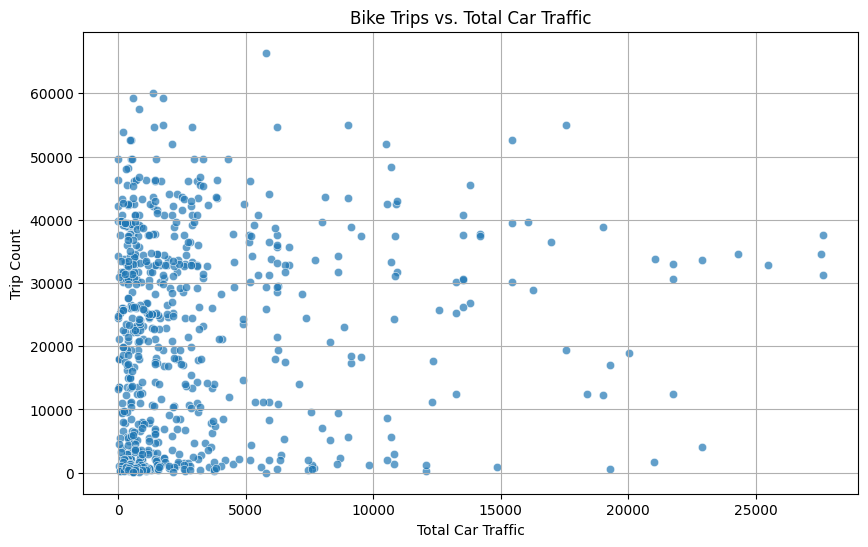

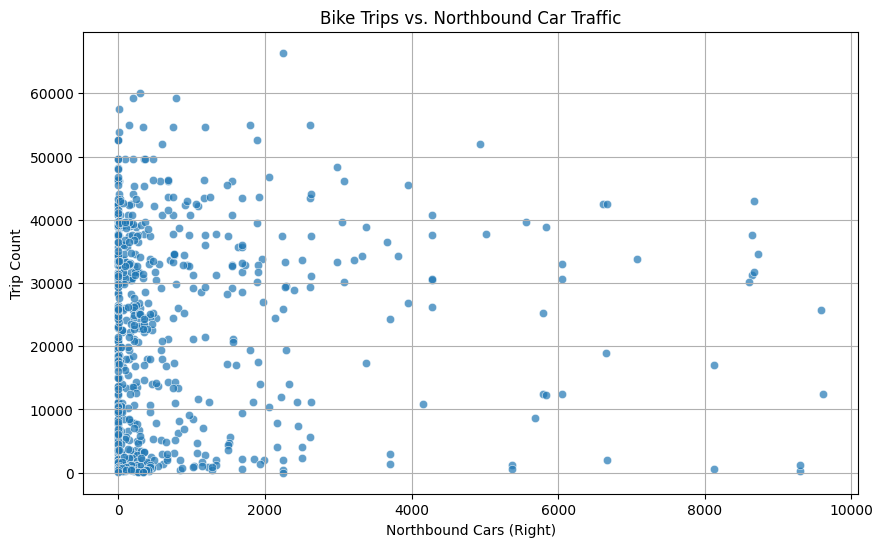

In [14]:
#mcreating visuals to see relationship between traffic and bike trips
# Correlation Matrix with Traffic Metrics
station_trip_weather_traffic['total_bike_traffic'] = (station_trip_weather_traffic[['nx_bike', 'sx_bike', 'ex_bike', 'wx_bike']].sum(axis=1)) # all bike traffic data
station_trip_weather_traffic['total_peds'] = (station_trip_weather_traffic[['nx_peds', 'sx_peds', 'ex_peds', 'wx_peds']].sum(axis=1)) #all pedestrian traffic data
station_trip_weather_traffic['total_cars'] = (station_trip_weather_traffic[['sb_cars_r', 'nb_cars_r', 'wb_cars_r', 'eb_cars_r']].sum(axis=1)) #all car traffic data
traffic_corr = station_trip_weather_traffic[[
    'trip_count', 'total_bike_traffic', 'total_peds', 'total_cars',
    'sb_cars_r', 'nb_cars_r', 'wb_cars_r', 'eb_cars_r',
    'sb_truck_r', 'nb_truck_r', 'wb_truck_r', 'eb_truck_r',
    'nx_bike', 'sx_bike', 'ex_bike', 'wx_bike',
    'nx_peds', 'sx_peds', 'ex_peds', 'wx_peds'
]].corr() #running a correlation between total bike trips and all traffic metrics
# Heatmap of Correlation Matrix
plt.figure(figsize=(14, 12))
sns.heatmap(traffic_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Bike Trips and Traffic Metrics')
plt.show()
# Scatter Plot: Trips vs. Total Bike Traffic
plt.figure(figsize=(10, 6))
sns.scatterplot(data=station_trip_weather_traffic, x='total_bike_traffic', y='trip_count', alpha=0.7)
plt.title('Bike Trips vs. Total Bike Traffic')
plt.xlabel('Total Bike Traffic')
plt.ylabel('Trip Count')
plt.grid(True)
plt.show()
# Scatter Plot: Trips vs. Total Pedestrians
plt.figure(figsize=(10, 6))
sns.scatterplot(data=station_trip_weather_traffic, x='total_peds', y='trip_count', alpha=0.7)
plt.title('Bike Trips vs. Total Pedestrian Traffic')
plt.xlabel('Total Pedestrian Traffic')
plt.ylabel('Trip Count')
plt.grid(True)
plt.show()
# Scatter Plot: Trips vs. Total Cars
plt.figure(figsize=(10, 6))
sns.scatterplot(data=station_trip_weather_traffic, x='total_cars', y='trip_count', alpha=0.7)
plt.title('Bike Trips vs. Total Car Traffic')
plt.xlabel('Total Car Traffic')
plt.ylabel('Trip Count')
plt.grid(True)
plt.show()
# Scatter Plot: Trips vs. Northbound Cars
plt.figure(figsize=(10, 6))
sns.scatterplot(data=station_trip_weather_traffic, x='nb_cars_r', y='trip_count', alpha=0.7)
plt.title('Bike Trips vs. Northbound Car Traffic')
plt.xlabel('Northbound Cars (Right)')
plt.ylabel('Trip Count')
plt.grid(True)
plt.show()

Calculating average bike trip counts and the average total traffic across all stations. Using these metrics for comparison, I create thresholds. Stations with high traffic (above the average total traffic) and low bike usage (below the average trip count). Using the thresholds I identify "ineffective" bike stations that have high traffic but low bike usage.

In [15]:
# Create one column that captures bike, pedestrain and car traffic
station_trip_weather_traffic['total_traffic'] = (station_trip_weather_traffic[['total_bike_traffic', 'total_peds', 'total_cars']].sum(axis=1))
# Calculate average trip count for comparisons
average_trip_count = station_trip_weather_traffic['trip_count'].mean()
# Calculate average total traffic for coparisons
average_total_traffic = station_trip_weather_traffic['total_traffic'].mean()
# Define high traffic and low bike usage
station_trip_weather_traffic['high_traffic'] = station_trip_weather_traffic['total_traffic'] > average_total_traffic
station_trip_weather_traffic['low_bike_usage'] = station_trip_weather_traffic['trip_count'] < average_trip_count
# Filter for ineffective bike stations
ineffective_stations = station_trip_weather_traffic[
    station_trip_weather_traffic['high_traffic'] & station_trip_weather_traffic['low_bike_usage']
]
print("Number of ineffective bike stations:", len(ineffective_stations))

Number of ineffective bike stations: 42


Creating a chart of the top 15 ineffective stations

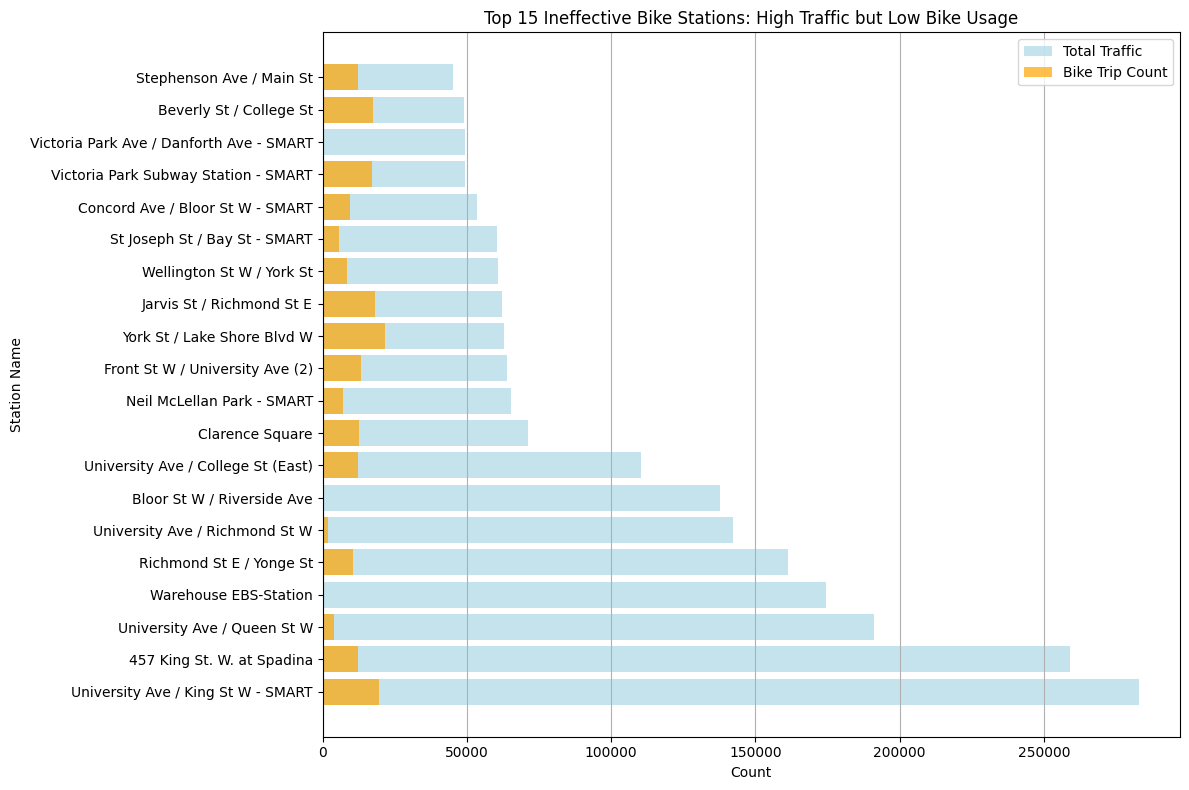

In [16]:
import matplotlib.pyplot as plt
# Sort ineffective stations by total traffic in descending order and select top 15
top_ineffective_stations = ineffective_stations.sort_values(by='total_traffic', ascending=False).head(20)
# Create a horizontal bar plot for the top 15 ineffective stations
plt.figure(figsize=(12, 8))
# Set the bar positions
y_pos = range(len(top_ineffective_stations))
# Plot total traffic and bike trip count as separate bars
plt.barh(y_pos, top_ineffective_stations['total_traffic'], label='Total Traffic', color='lightblue', alpha=0.7)
plt.barh(y_pos, top_ineffective_stations['trip_count'], label='Bike Trip Count', color='orange', alpha=0.7)
# Add labels and title
plt.title('Top 15 Ineffective Bike Stations: High Traffic but Low Bike Usage')
plt.xlabel('Count')
plt.ylabel('Station Name')
plt.yticks(y_pos, top_ineffective_stations['station_name'])
# Show legend
plt.legend(loc='upper right')
# Adjust layout
plt.tight_layout()
plt.grid(axis='x')
plt.show()

**Next steps..**
From the analysis I learned that weather seems to have a stronger relationship with the number of bike trips than traffic data. So new stations should be locations with high number of pedestrations and high precipation and low minimum temp (check the correlation matrix)